In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, f1_score, recall_score,
                             precision_score, accuracy_score)
from xgboost import XGBClassifier, plot_importance
import joblib
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/SumantaSethi/Bank-Customer-Churn-Prediction/main/Churn_Modelling_Clean.csv')
X = df.drop('Exited', axis=1)
y = df['Exited']

# ENCODE CATEGORICAL VARIABLES

In [6]:
X_encoded = X.copy()
le_geo = LabelEncoder()
X_encoded['Geography'] = le_geo.fit_transform(X['Geography'])
le_gender = LabelEncoder()
X_encoded['Gender'] = le_gender.fit_transform(X['Gender'])


# TRAIN-TEST SPLIT

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
      X_encoded, y, test_size=0.2, random_state=42, stratify=y
      )

# CREATE XGBOOST MODEL

In [9]:

# Calculate scale_pos_weight to handle class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    random_state=42,
        scale_pos_weight=scale_pos_weight,  # Handle imbalance
            eval_metric='logloss',
                use_label_encoder=False
                )

# HYPERPARAMETER TUNING

In [11]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    xgb_model,
    param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV recall: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV recall: 0.7528


# EVALUATE

In [12]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n📊 METRICS:")
print(f"   Accuracy:  {accuracy:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1 Score:  {f1:.4f}")
print(f"   ROC-AUC:   {roc_auc:.4f}")

print("\n📋 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, target_names=['Stayed', 'Churned']))



📊 METRICS:
   Accuracy:  0.7870
   Precision: 0.4848
   Recall:    0.7469
   F1 Score:  0.5880
   ROC-AUC:   0.8631

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Stayed       0.92      0.80      0.86      1593
     Churned       0.48      0.75      0.59       407

    accuracy                           0.79      2000
   macro avg       0.70      0.77      0.72      2000
weighted avg       0.84      0.79      0.80      2000



# VISUALIZATIONS

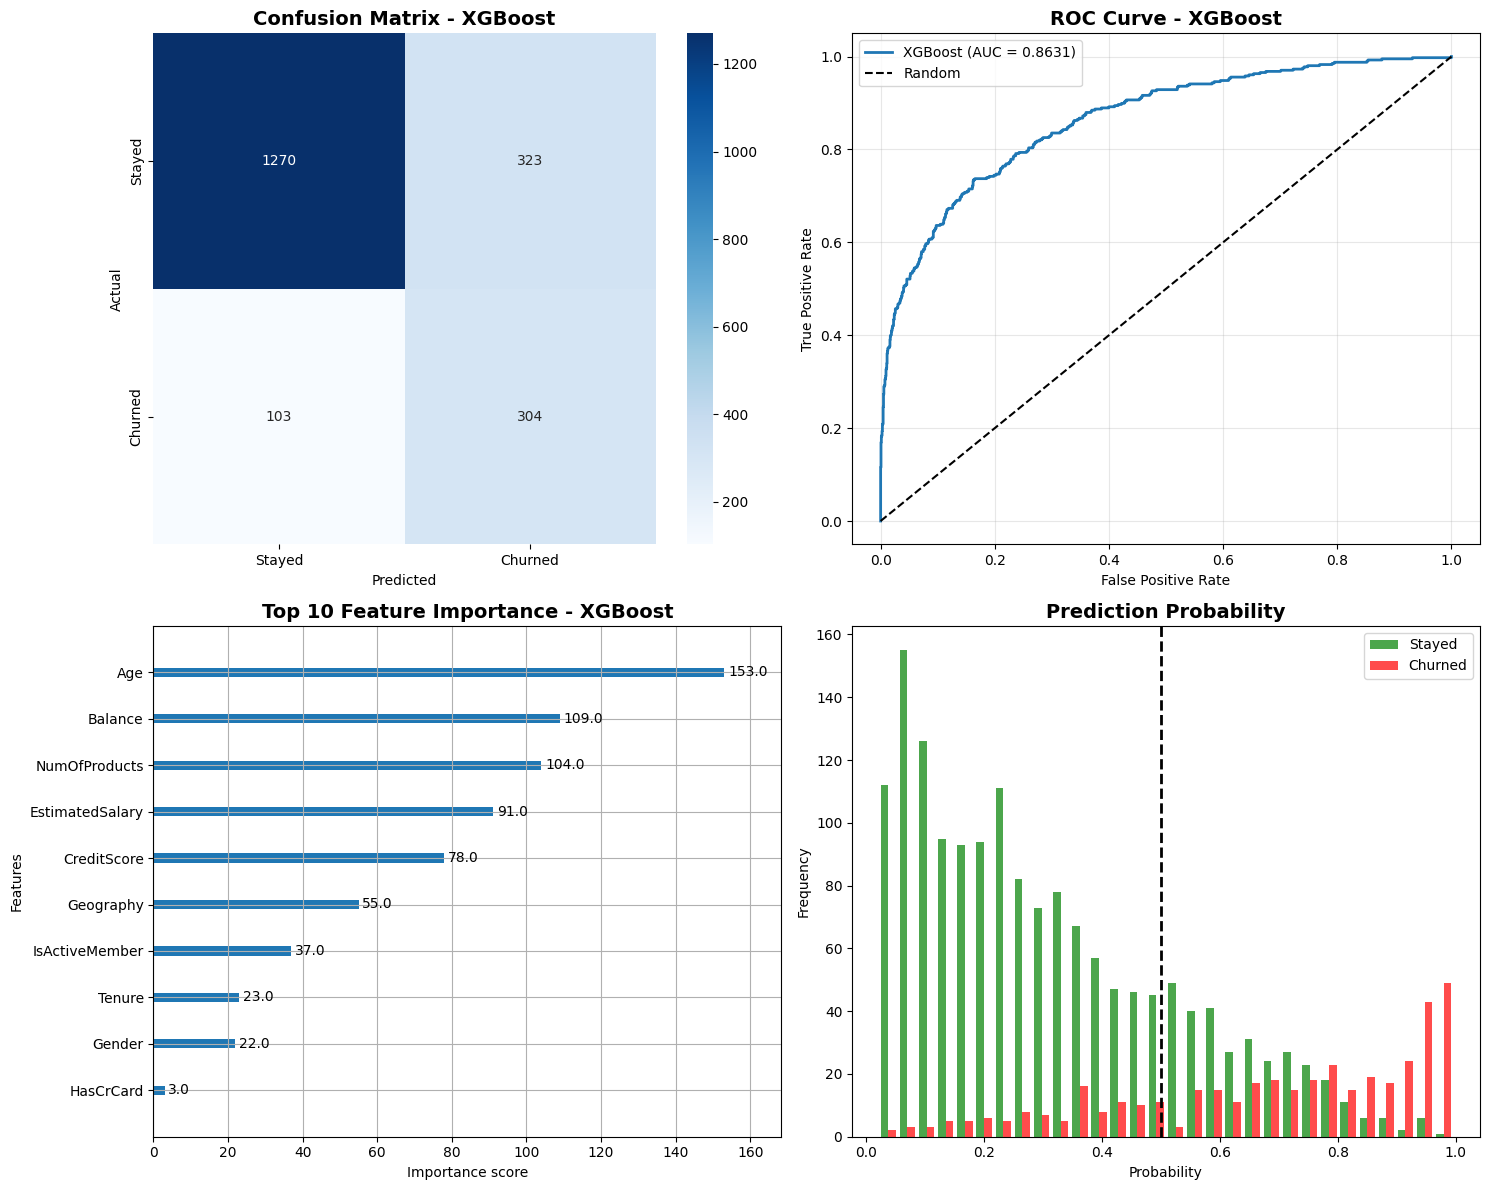

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Stayed', 'Churned'],
            yticklabels=['Stayed', 'Churned'])
axes[0, 0].set_title('Confusion Matrix - XGBoost', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'XGBoost (AUC = {roc_auc:.4f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 1].set_title('ROC Curve - XGBoost', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Feature Importance
plot_importance(best_model, ax=axes[1, 0], max_num_features=10)
axes[1, 0].set_title('Top 10 Feature Importance - XGBoost', fontsize=14, fontweight='bold')

# Prediction Distribution
axes[1, 1].hist([y_pred_proba[y_test==0], y_pred_proba[y_test==1]],
               bins=30, label=['Stayed', 'Churned'],
               color=['green', 'red'], alpha=0.7)
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', linewidth=2)
axes[1, 1].set_title('Prediction Probability', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Probability')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()